Модель Prophet 
---


 - data - дата
 - value - таргет метрика
  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.linear_model import LinearRegression
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
from fbprophet import Prophet

In [2]:
df = pd.read_csv(r'C:\Users\Георгий\Projects\revenue_for_prophet.csv')

In [3]:
df = df.drop(columns=['Unnamed: 0'])

In [4]:
# Если неоходимо задать имена колонкам для манимуляций с типами данных.
df.columns=['Date', 'Revenue']

In [5]:
df['Revenue'] = df['Revenue'].astype('float64')

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# Убираем "NA"
df.dropna(how="any", inplace=True)

In [8]:
# Если необходимо добавить индекс, модель ругается на формат индекса.
df.set_index('Date',inplace = True)

In [9]:
# Проверяем данные на выбросы.
df.describe()

,Revenue
count,366.000000
mean,49572.022856
std,24684.820656
min,15754.649716
25%,34022.746952
50%,42195.054477
75%,57644.489398
max,241601.658924


In [10]:
# Берем за выбросы значения, превосходящие (среднее + 3 отклонения).
outliers = df[df['Revenue'] > df['Revenue'].mean() + 3 * df['Revenue'].std()]

In [11]:
# Выводим выбросы. 
outliers

,Revenue
Date,
2020-11-24,206828.749443
2020-11-25,241601.658924
2020-11-26,161757.229080
2020-12-25,148502.098341
2021-04-21,149859.910969
2021-07-01,145727.717559


In [12]:
df['Revenue'].mean()

49572.02285624763

df.to_csv(r'C:\Users\Георгий\Projects\cleared_data.csv')

In [13]:
df = pd.read_csv(r'C:\Users\Георгий\Projects\cleared_data.csv')

In [14]:
# Сбрасываем индекс даты, возвращаем формат на стандартный вид "ГГГГ-ММ-ДД" и снова устанавливаем индекс для даты.
#df = df.reset_index()
df['Date'] = df['Date'].apply(dt.datetime.fromordinal)
df.set_index('Date',inplace = True)

In [15]:
# Визуализируем отчищенные данные. 
# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df['Revenue'],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [17]:
plotly_df(df.resample('w').apply(sum), title = 'Revenue')

In [18]:
# Импортируем библиотеку
from fbprophet import Prophet
# Указываем размер хвоста для сравнения данных модели и фактических данных.
predictions = 30

# приводим dataframe к нужному формату
df = df.reset_index()
df.columns = ['ds', 'y']

# отрезаем из обучающей выборки последние 30 точек(по желанию), чтобы измерить на них качество
train_df = df[:-predictions] 

In [19]:
# Cоздаем объект класса Prophet с учетом(по желанию) сезонности и обучаем его.
m = Prophet(daily_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

In [20]:
# С помощью вспомогательной функции Prophet.make_future_dataframe создаем dataframe, 
# который содержит все исторические временные точки и еще 30 дней, 
# для которых мы хотели построить прогноз.
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

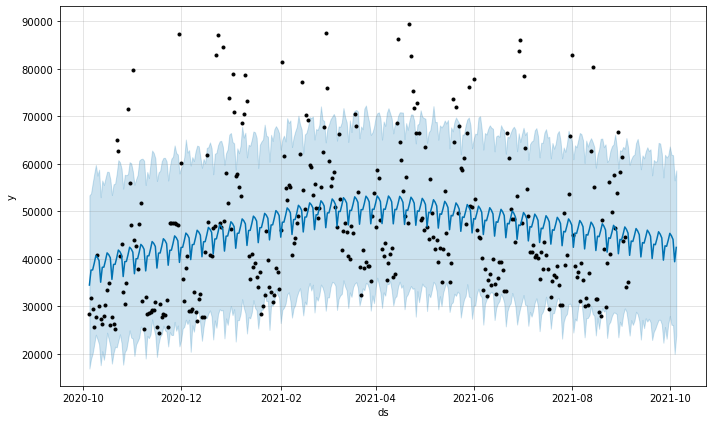

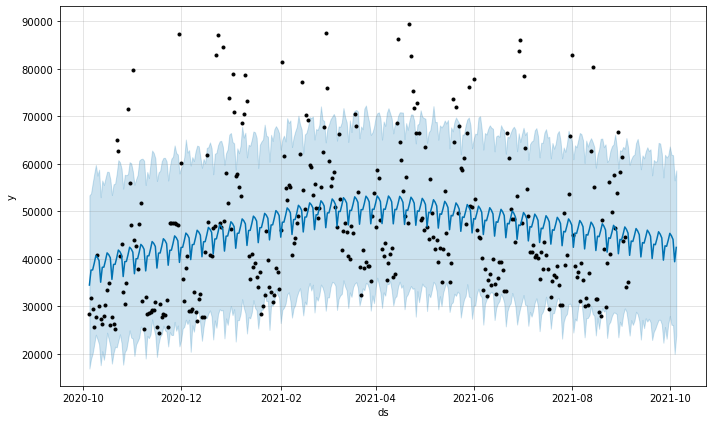

In [21]:
# Метод Prophet.plot отображает прогноз
m.plot(forecast)

In [22]:
# Созданный моделью Датафрейм прогноза.
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-05,30306.888949,16911.977796,53348.714634,30306.888949,30306.888949,4174.705777,4174.705777,4174.705777,7921.534819,7921.534819,7921.534819,-3746.829042,-3746.829042,-3746.829042,0.0,0.0,0.0,34481.594726
1,2020-10-06,30391.947254,18923.254407,53752.316032,30391.947254,30391.947254,7234.796920,7234.796920,7234.796920,7921.534819,7921.534819,7921.534819,-686.737899,-686.737899,-686.737899,0.0,0.0,0.0,37626.744173
2,2020-10-07,30477.005559,20078.237034,55896.771497,30477.005559,30477.005559,7184.113901,7184.113901,7184.113901,7921.534819,7921.534819,7921.534819,-737.420918,-737.420918,-737.420918,0.0,0.0,0.0,37661.119459
3,2020-10-08,30562.063864,22046.999525,57882.747198,30562.063864,30562.063864,8504.689219,8504.689219,8504.689219,7921.534819,7921.534819,7921.534819,583.154400,583.154400,583.154400,0.0,0.0,0.0,39066.753083
4,2020-10-09,30647.122168,24028.305027,59739.749757,30647.122168,30647.122168,10004.443308,10004.443308,10004.443308,7921.534819,7921.534819,7921.534819,2082.908489,2082.908489,2082.908489,0.0,0.0,0.0,40651.565477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-10-01,35354.992091,27967.313375,63639.488072,35174.868135,35519.463516,10004.443308,10004.443308,10004.443308,7921.534819,7921.534819,7921.534819,2082.908489,2082.908489,2082.908489,0.0,0.0,0.0,45359.435400
362,2021-10-02,35306.869037,26126.014659,61895.583068,35111.431680,35484.842772,9548.390375,9548.390375,9548.390375,7921.534819,7921.534819,7921.534819,1626.855556,1626.855556,1626.855556,0.0,0.0,0.0,44855.259412
363,2021-10-03,35258.745983,26062.246689,61815.269351,35052.678376,35445.696197,8799.604234,8799.604234,8799.604234,7921.534819,7921.534819,7921.534819,878.069415,878.069415,878.069415,0.0,0.0,0.0,44058.350217
364,2021-10-04,35210.622929,19981.148520,56513.555948,34992.795004,35406.328331,4174.705777,4174.705777,4174.705777,7921.534819,7921.534819,7921.534819,-3746.829042,-3746.829042,-3746.829042,0.0,0.0,0.0,39385.328705


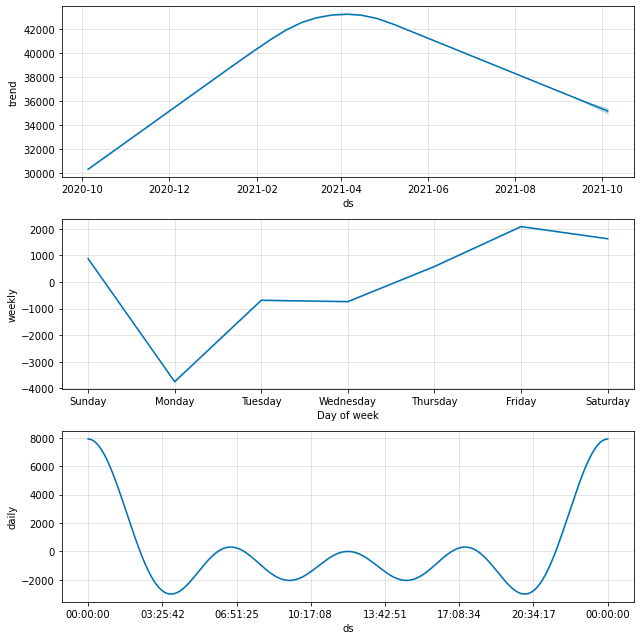

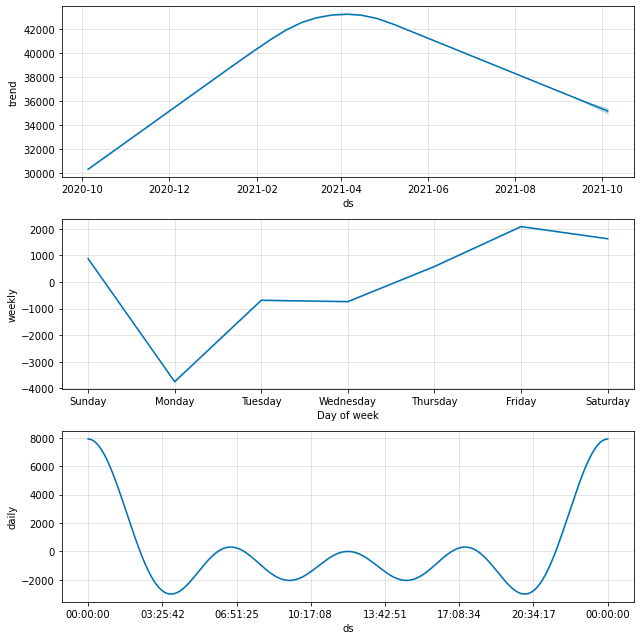

In [23]:
# Функция Prophet.plot_components позволяет посмотреть отдельно на компоненты: тренд, годовую и недельную сезонность. 
# Если при построении модели были заданы аномальные дни/праздники, то они также будут отображаться на этом графике.
m.plot_components(forecast)

In [24]:
# Выбираем интересующие нас колонки из forecast и и объединяем с исходными наблюдениями по индексу.
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [25]:
# Сморим, что всё ок.
cmp_df

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-10-05,34481.594726,16911.977796,53348.714634,28348.879581
2020-10-06,37626.744173,18923.254407,53752.316032,31724.599510
2020-10-07,37661.119459,20078.237034,55896.771497,29435.249501
2020-10-08,39066.753083,22046.999525,57882.747198,25608.419529
2020-10-09,40651.565477,24028.305027,59739.749757,27823.869544
...,...,...,...,...
2021-10-01,45359.435400,27967.313375,63639.488072,65125.208803
2021-10-02,44855.259412,26126.014659,61895.583068,37878.139316
2021-10-03,44058.350217,26062.246689,61815.269351,33081.629420


# Можно выгрузить Датафрейм для дальнейшего использования в других инструментах.
cmp_df.to_csv('___.csv', index=True)

In [26]:
# Устанавливаем размерность массива для работы в NumPy.
cmp_df['y'] = cmp_df['y'].replace(0, 0.1)

In [27]:
# Рассчитываем MAPE (mean absolute percentage error) — это средняя абсолютная ошибка нашего прогноза.
# Рассчитываем MAE - mean absolute error, чтобы понимать, на сколько ошибается модель в абсолютных величинах.
import numpy as np

cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

print ('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print ('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))



MAPE 41.94201667147755
MAE 13301.3040674716


In [28]:
cmp_df

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2020-10-05,34481.594726,16911.977796,53348.714634,28348.879581,-6132.715144,-21.633007
2020-10-06,37626.744173,18923.254407,53752.316032,31724.599510,-5902.144663,-18.604316
2020-10-07,37661.119459,20078.237034,55896.771497,29435.249501,-8225.869958,-27.945644
2020-10-08,39066.753083,22046.999525,57882.747198,25608.419529,-13458.333553,-52.554331
2020-10-09,40651.565477,24028.305027,59739.749757,27823.869544,-12827.695933,-46.103206
...,...,...,...,...,...,...
2021-10-01,45359.435400,27967.313375,63639.488072,65125.208803,19765.773404,30.350418
2021-10-02,44855.259412,26126.014659,61895.583068,37878.139316,-6977.120096,-18.419912
2021-10-03,44058.350217,26062.246689,61815.269351,33081.629420,-10976.720797,-33.180714


In [29]:
# функция для визуализации построенного прогноза
def show_forecast(cmp_df, num_predictions, num_values):
    # верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="#ff0000"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    # прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    # нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="#ff0000"),
        line=dict(width=0),
        mode='lines')

    # фактические значения
    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Revenue by date',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, predictions, 200)
